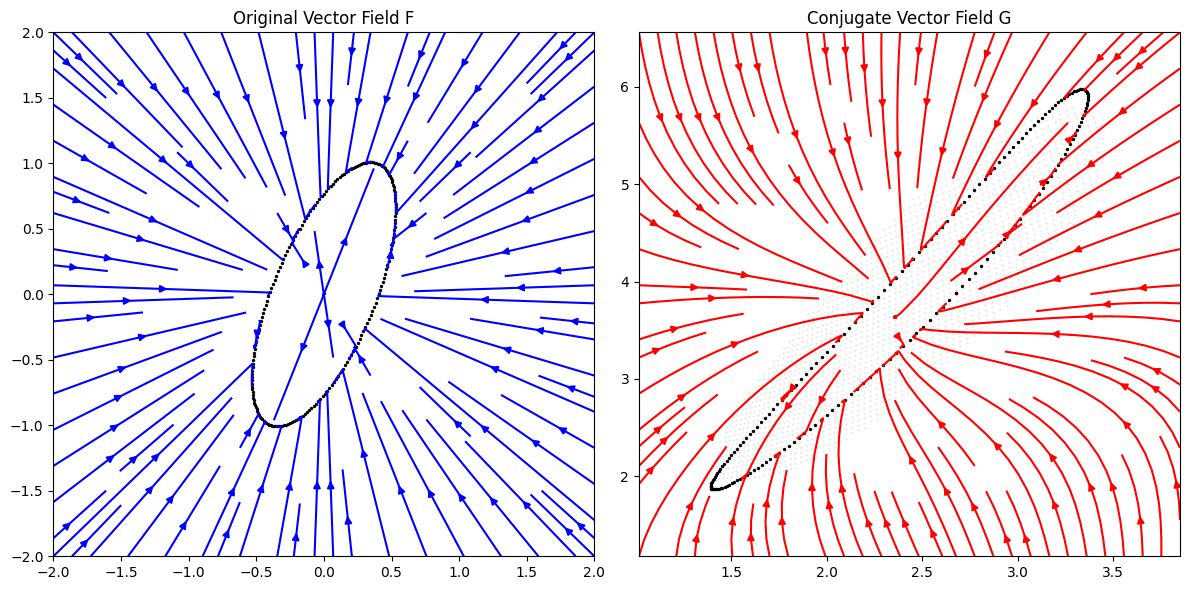

In [31]:
import torch
import torch.nn as nn
import torchdiffeq
import matplotlib.pyplot as plt
import numpy as np
from typing import TypeAlias
from functools import partial
nn_activation: TypeAlias = torch.nn.modules.activation
odeint = partial(torchdiffeq.odeint, options={"dtype":torch.float32})

class phi(nn.Module):
    def __init__(self, dim: int, hidden: int = 96, activation:nn_activation = nn.GELU, repetitions: int = 0):
        super().__init__()
        layers = [nn.Linear(dim, hidden), activation()]
        for _ in range(repetitions):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(activation())
        layers.append(nn.Linear(hidden, dim))
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        return self.net(z)

class ConjugateSystem(nn.Module):
    def __init__(self, diffeo_model: nn.Module, t: float = 1.0):
        super().__init__()
        self.model = torch.compile(lambda t,x: diffeo_model(x))  # compile the ODE model
        self.T = t

    def flow_forward(self, x):
        t = torch.tensor([0., self.T])
        return odeint(self.model, x, t)[-1]

    def flow_inverse(self, y):
        t = torch.tensor([self.T, 0.])
        return odeint(self.model, y, t)[-1]

    def conjugate_vector_field(self, y, F):
        x = self.flow_inverse(y)
        Fx = F(x)
        x.requires_grad_(True)
        y_fwd = self.flow_forward(x)
        return torch.autograd.grad(y_fwd, x, grad_outputs=Fx, retain_graph=False)[0]

    def conjugate_vector_field_batch(self, Y, F):
        return torch.stack([self.conjugate_vector_field(y, F) for y in Y])

def ellipse_transform_from_A(A: torch.Tensor) -> torch.Tensor:
    # A is PSD (2x2), factorize such that x^T A x = 1
    # Find L where x = L * u (u on unit circle)
    L_inv = torch.linalg.cholesky(A)
    L = torch.linalg.inv(L_inv)
    return L  # mapping from unit circle to ellipse

def sample_ellipse_perimeter_from_A(n_points: int, A: torch.Tensor) -> torch.Tensor:
    L = ellipse_transform_from_A(A)
    t = torch.linspace(0, 2 * torch.pi, n_points)
    circle_points = torch.stack([torch.cos(t), torch.sin(t)], dim=-1)
    return circle_points @ L  # map to ellipse


# def f(x):
#     r = torch.norm(x, dim=-1, keepdim=True)
#     return x * (1 - r)

def visualize_conjugacy_with_invariant(conjugate_system, F, bounds=(-2, 2), n_points=20, A: torch.Tensor = torch.eye(2)):
    with torch.device("cpu"):
        xs = np.linspace(bounds[0], bounds[1], n_points)
        ys = np.linspace(bounds[0], bounds[1], n_points)
        grid_x, grid_y = np.meshgrid(xs, ys)
        points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1), dtype=torch.float32)

        F_vals = torch.stack([F(p) for p in points])
        U_F = F_vals[:, 0].reshape(n_points, n_points).cpu().numpy()
        V_F = F_vals[:, 1].reshape(n_points, n_points).cpu().numpy()

        # Original unit circle
        # theta = np.linspace(0, 2 * np.pi, 200)
        # circle = np.stack([np.cos(theta), np.sin(theta)], axis=-1)
        circle = sample_ellipse_perimeter_from_A(200, A)
        circle_torch = circle.to(torch.float32)
        mapped_circle = conjugate_system.flow_forward(circle_torch).detach().cpu().numpy()

        # Fill the disk
        disk_x, disk_y = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))
        mask = disk_x**2 + disk_y**2 <= 1
        disk_points = np.stack([disk_x[mask], disk_y[mask]], axis=-1)
        disk_torch = torch.tensor(disk_points, dtype=torch.float32)
        mapped_disk = conjugate_system.flow_forward(disk_torch).detach().cpu().numpy()

        # Compute bounding box for mapped disk, add margin
        min_x, min_y = mapped_disk.min(axis=0)
        max_x, max_y = mapped_disk.max(axis=0)
        margin_x = 0.2 * (max_x - min_x)
        margin_y = 0.2 * (max_y - min_y)
        bounds_g = ((min_x - margin_x), (max_x + margin_x), (min_y - margin_y), (max_y + margin_y))

        # New grid for G centered on mapped disk
        xs_g = np.linspace(bounds_g[0], bounds_g[1], n_points)
        ys_g = np.linspace(bounds_g[2], bounds_g[3], n_points)
        grid_x_g, grid_y_g = np.meshgrid(xs_g, ys_g)
        points_g = torch.tensor(np.stack([grid_x_g.ravel(), grid_y_g.ravel()], axis=-1), dtype=torch.float32)

        # Compute G on the new grid
        G_vals = conjugate_system.conjugate_vector_field(points_g, F)
        U_G = G_vals[:, 0].reshape(n_points, n_points).cpu().numpy()
        V_G = G_vals[:, 1].reshape(n_points, n_points).cpu().numpy()

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].streamplot(xs, ys, U_F, V_F, color='blue', density=1)
        axs[0].scatter(circle[:, 0], circle[:, 1], s=2, color='black')
        axs[0].set_title('Original Vector Field F')
        axs[0].set_xlim(bounds)
        axs[0].set_ylim(bounds)

        axs[1].streamplot(xs_g, ys_g, U_G, V_G, color='red', density=1)
        axs[1].scatter(mapped_circle[:, 0], mapped_circle[:, 1], s=2, color='black')
        axs[1].scatter(mapped_disk[:, 0], mapped_disk[:, 1], s=1, alpha=0.1, color='gray')
        axs[1].set_title('Conjugate Vector Field G')
        axs[1].set_xlim([bounds_g[0], bounds_g[1]])
        axs[1].set_ylim([bounds_g[2], bounds_g[3]])

        plt.tight_layout()
        plt.show()

torch.manual_seed(0)
dim = 2
model = phi(dim, repetitions=1, hidden=32)
conjugate_system = ConjugateSystem(model, t=20.0)

A = torch.randn(2,2)
A = A @ A.T  # Ensure A is positive definite
def f(x):
    r = torch.sqrt(torch.sum((x @ A) * x, dim=-1, keepdim=True))
    return x * (1 - r)

visualize_conjugacy_with_invariant(conjugate_system, f, n_points=100, A=A)

In [42]:
from typing import Callable, Union
import torch
from torch import Tensor
from torch import nn

VectorField = Union[nn.Module, Callable[[Tensor], Tensor]]

class LieDerivative(nn.Module):
    """
    Computes the Lie bracket [X, Y] = X·∇Y − Y·∇X of two vector fields X, Y : ℝⁿ → ℝⁿ,
    in a fully differentiable way.
    X, Y may be nn.Modules or plain callables.
    """
    def __init__(self,
                 f: VectorField,
                 g: VectorField) -> None:
        super().__init__()

        if isinstance(f, nn.Module):
            self.X = f
        else:
            mod = nn.Module()
            mod.forward = f  # type: ignore[attr-defined]
            self.X = mod

        if isinstance(g, nn.Module):
            self.Y = g
        else:
            mod = nn.Module()
            mod.forward = g  # type: ignore[attr-defined]
            self.Y = mod

    def forward(self, x: Tensor) -> Tensor:

        f, g, x = self._eval_vfields(x)

        dg = torch.autograd.grad(
            outputs=g,
            inputs=x,
            grad_outputs=f,
            create_graph=True,
            retain_graph=True
        )[0]

        # directional derivative dX = ∇X(x) · Y_x
        df = torch.autograd.grad(
            outputs=f,
            inputs=x,
            grad_outputs=g,
            create_graph=True
        )[0]

        return dg - df

    def loss(self,x):
        f, g, x = self._eval_vfields(x)

        dg = torch.autograd.grad(
            outputs=g,
            inputs=x,
            grad_outputs=f,
            create_graph=True,
            retain_graph=True
        )[0]

        # directional derivative dX = ∇X(x) · Y_x
        df = torch.autograd.grad(
            outputs=f,
            inputs=x,
            grad_outputs=g,
            create_graph=True
        )[0]
        return torch.norm(dg - df,p=2)/torch.norm(dg,p=2)

    def _eval_vfields(self, x):
        if not x.requires_grad:
            x = x.clone().detach().requires_grad_(True)
        f = self.X(x)
        g = self.Y(x)
        return f, g, x

In [63]:
def f_generator(x:Tensor, A) -> Tensor:
    r = torch.sqrt(torch.sum((x @ A) * x, dim=-1, keepdim=True))
    return x * (1 - r)

vfield_kind = "ellipse"
match vfield_kind:
    case "id":
        A = torch.eye(2)
        f = lambda x:f_generator(x, A)
    case "so2":
        torch.tensor([[0., -1.], [1., 0.]])
        f = lambda x:f_generator(x, A)
    case "ellipse":
        A = torch.randn(2,2)
        A = A @ A.T  # Ensure A is positive definite
        torch.tensor([[0., -1.], [1., 0.]])
        f = lambda x:f_generator(x, A)
    case _:
        raise ValueError(f"Unknown base {vfield_kind}")


def g(x: Tensor) -> Tensor:
    return torch.stack([ x[...,1], -x[...,0] ], dim=-1)

x = sample_ellipse_perimeter_from_A(200, A)

lie = LieDerivative(f, g)
lie.loss(x).backward()

In [65]:
lie.loss(x.requires_grad_()).backward()